# Première implementation des modèles

Ce notebook est fait pour faire des tests sur l'implémentation des modèles, de la génération des données, des graphiques, etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nprd
import pandas as pd

from smc_movement_models.plots import plot_graph_values, plot_real_data

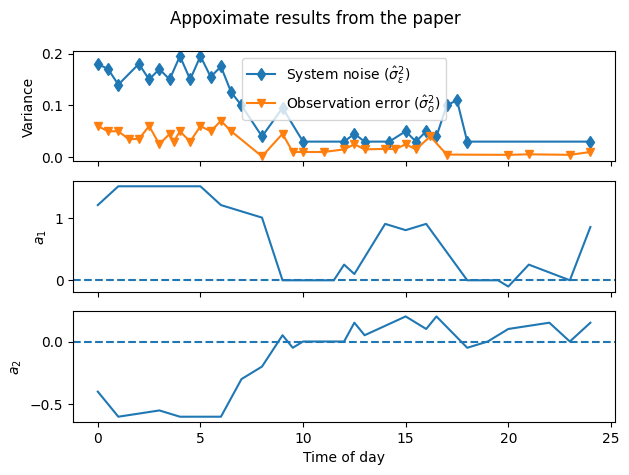

In [3]:
gv_fig = plot_graph_values(figsize=None)

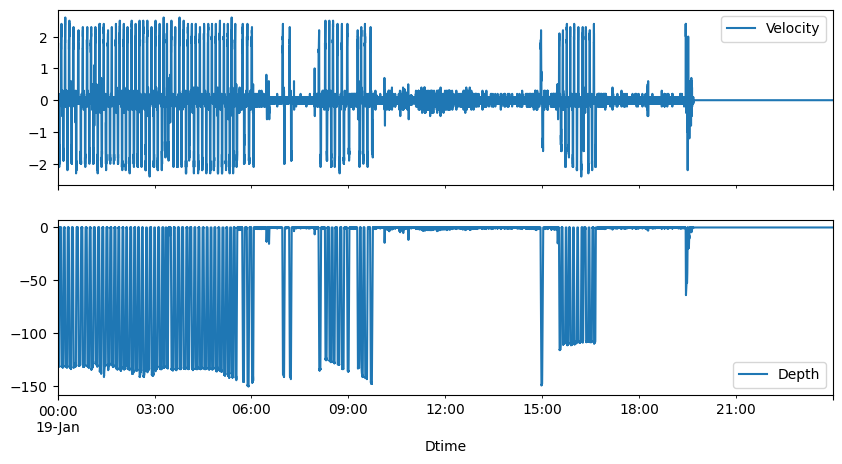

In [4]:
day_fig = plot_real_data("../data/19_01_2008.csv", figsize=(10, 5))

In [5]:
day = pd.read_csv("../data/19_01_2008.csv", parse_dates=[0])

In [6]:
import numpy as np
import particles
import particles.distributions as dists
import particles.state_space_models as ssms
from particles.distributions import Gamma, IndepProd, Normal

from smc_movement_models.models import MarineSSM

In [7]:
window = day[:312]["Depth"]
my_ssm_model = MarineSSM(z0=window[0], z1=window[1])
my_fk_model = ssms.Bootstrap(ssm=my_ssm_model, data=window)

In [14]:
my_alg = particles.SMC(fk=my_fk_model, N=200)
a1s = []
a2s = []
for i in range(len(window)):
    next(my_alg)
    a1s.append(my_alg.X[:, 2])
    a2s.append(my_alg.X[:, 3])
a1s = np.array(a1s)
a2s = np.array(a2s)

In [9]:
def run_smc(window, N=200, **kwargs):
    my_ssm_model = MarineSSM(z0=window[0], z1=window[1], **kwargs)
    my_fk_model = ssms.Bootstrap(ssm=my_ssm_model, data=window)
    my_alg = particles.SMC(fk=my_fk_model, N=N)

    a1s = []
    a2s = []
    for i in range(len(window)):
        next(my_alg)
        a1s.append(my_alg.X[:, 2])
        a2s.append(my_alg.X[:, 3])
    a1s = np.array(a1s)
    a2s = np.array(a2s)

    return a1s.mean(axis=1), a2s.mean(axis=1)

In [10]:
epsilon = 0.1
final_a1s = [0]
final_a2s = [0]
for m in range(10):
    a1s, a2s = run_smc(window=window, sigma_e=epsilon, a1=final_a1s[-1], a2=final_a2s[-1])
    final_a1s.append(a1s.mean())
    final_a2s.append(a2s.mean())
    epsilon *= 0.5

In [11]:
epsilon

9.765625e-05

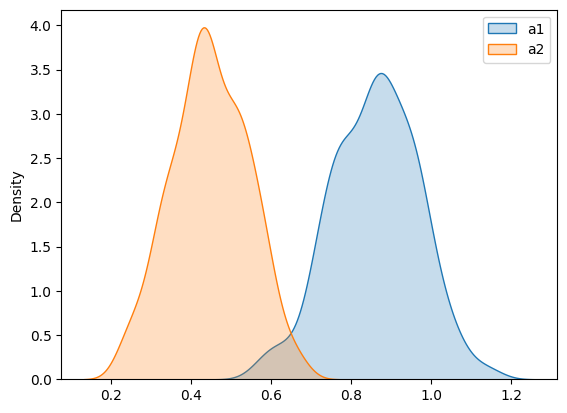

In [15]:
import seaborn as sns

sns.kdeplot(my_alg.X[:, 2], fill=True, label="a1")
sns.kdeplot(my_alg.X[:, 3], fill=True, label="a2")
plt.legend()

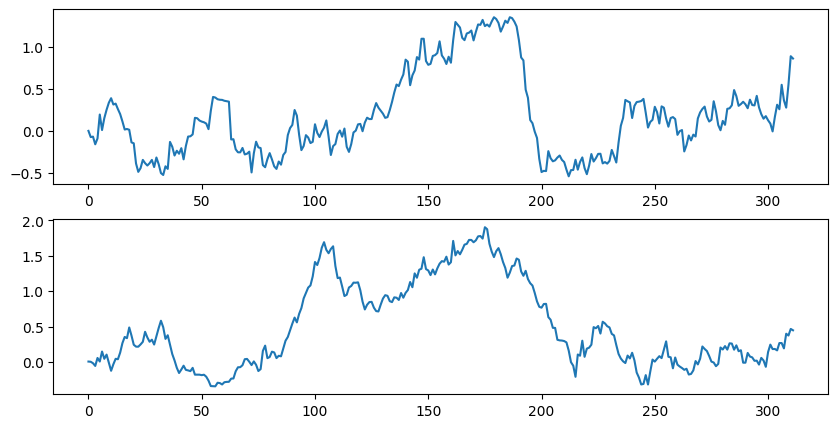

In [16]:
x_range = np.arange(len(window))
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(x_range, a1s.mean(axis=1))
axs[1].plot(x_range, a2s.mean(axis=1))